## Fitting Induction data to the SR plus another SR model using softmax rule

In [1]:
import os
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tesser import cython_fit
from tesser import util
from tesser import sr
import importlib

## Load data for all subjects

In [2]:
data_dir= "/mnt/c/Users/rodv2/Dropbox/tesser_successor/Data"
tdir = "/home/work-machine/Preston_Lab/tesser_successor/Data"
struct_all = util.load_struct(data_dir)
induct_all = util.load_induct(data_dir)
n_states =21

## Fit each individual subject

In [3]:
# Using a hybrid model function when model_type is set to multiple gamma another SR is used to fit 
fixed = {}
var_names = ['gamma', 'gamma2', 'alpha', 'tau', 'w']
var_bounds = {'gamma': [0, 1], 'gamma2': [0, 1], 'alpha': [0, 1], 'tau': [0, 10], 'w': [0, 1]}
results = cython_fit.fit_induct_indiv(struct_all, induct_all, fixed, var_names, var_bounds, split =False,
                               n_states=n_states, verbose=False, model_type='multiple gamma', model =[], split_list=[])

Estimating parameters for 100...
Estimating parameters for 101...
Estimating parameters for 102...
Estimating parameters for 103...
Estimating parameters for 104...
Estimating parameters for 105...
Estimating parameters for 106...
Estimating parameters for 107...
Estimating parameters for 108...
Estimating parameters for 109...
Estimating parameters for 110...
Estimating parameters for 111...
Estimating parameters for 112...
Estimating parameters for 113...
Estimating parameters for 114...
Estimating parameters for 115...
Estimating parameters for 116...
Estimating parameters for 117...
Estimating parameters for 119...
Estimating parameters for 120...
Estimating parameters for 121...
Estimating parameters for 122...
Estimating parameters for 123...
Estimating parameters for 124...
Estimating parameters for 125...
Estimating parameters for 126...
Estimating parameters for 127...
Estimating parameters for 128...
Estimating parameters for 129...
Estimating parameters for 130...
Estimating

In [4]:
results = results.set_index('subject')
results.head()

,gamma,gamma2,alpha,tau,w,log_like
subject,,,,,,
100,1.000000,0.362628,1.000000,4.075254,0.210007,-27.879912
101,0.992612,0.352730,0.726768,0.485572,0.433778,-25.324311
102,0.916006,0.709578,0.013471,0.035467,0.344618,-21.002741
103,0.000000,0.391974,0.998453,0.001123,0.798286,-24.430900
104,0.000000,0.820843,1.000000,0.280753,0.503043,-27.130966


In [5]:
results.to_csv(f"./Data/hybrid_results/hybrid_SR_free.csv")

## Get response probabilities for the fitted models

In [6]:
res_list = []
for subject in results.index.unique():
    subj_filter = f'SubjNum == {subject}'
    subj_struct = struct_all.query(subj_filter)
    subj_induct = induct_all.query(subj_filter)
    subj_param = results.loc[subject]
    param = {'alpha': subj_param['alpha'], 'gamma': subj_param['gamma'], 'gamma2': subj_param['gamma2'],
             'tau': subj_param['tau'], 'w' : subj_param['w']}
    res = cython_fit.assess_induct_fit_subject_hybrid(subj_struct, subj_induct, param, n_states, False,'multiple gamma')
    
    res_list.append(res)
fitted = pd.concat(res_list, axis=0)

In [7]:
fitted

,SubjNum,TrialNum,QuestType,Environment,Source,Accuracy
0,100,1,Prim,ocean,Data,0.000000
1,100,2,Bound2,desert,Data,0.000000
2,100,3,Prim,desert,Data,1.000000
3,100,4,Prim,ocean,Data,1.000000
4,100,5,Prim,ocean,Data,0.000000
...,...,...,...,...,...,...
79,138,38,Prim,desert,Model,0.498803
80,138,39,Prim,forest,Model,0.500071
81,138,40,Prim,ocean,Model,0.542695
82,138,41,Bound1,forest,Model,0.388643


## Plot individual differences in induction

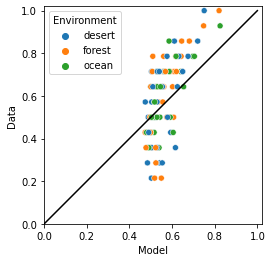

In [8]:
m = fitted.groupby(['Source', 'SubjNum', 'Environment'])['Accuracy'].mean().unstack(level=0)
g = sns.scatterplot(x='Model', y='Data', hue='Environment', data=m.reset_index());
g.set_xlim(0, 1.02);
g.set_ylim(0, 1.02);
g.set_aspect(1);
g.plot((0, 1), (0, 1), '-k');

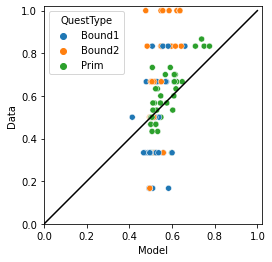

In [9]:
m = fitted.groupby(['Source', 'SubjNum', 'QuestType'])['Accuracy'].mean().unstack(level=0)
g = sns.scatterplot(x='Model', y='Data', hue='QuestType', data=m.reset_index());
g.set_xlim(0, 1.02);
g.set_ylim(0, 1.02);
g.set_aspect(1);
g.plot((0, 1), (0, 1), '-k');

## Plot group means

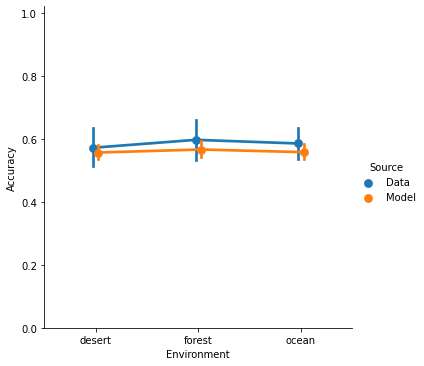

In [10]:
m = fitted.groupby(['Source', 'SubjNum', 'Environment'])['Accuracy'].mean()
g = sns.catplot(kind='point', x='Environment', y='Accuracy', 
                hue='Source', dodge=True, data=m.reset_index())
g.set(ylim=(0, 1.02));

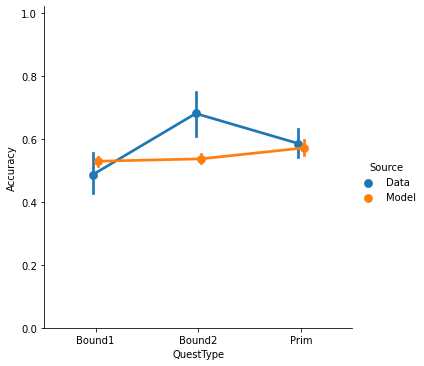

In [11]:
m = fitted.groupby(['Source', 'SubjNum', 'QuestType'])['Accuracy'].mean()
g = sns.catplot(kind='point', x='QuestType', y='Accuracy', 
                hue='Source', dodge=True, data=m.reset_index())
g.set(ylim=(0, 1.02));

## Add weights by question

In [12]:

fixed = {}
var_names = ['gamma',  'gamma2', 'alpha', 'tau', 'w_prim' ,'w_bound1', 'w_bound2']
var_bounds = {'gamma': [0, 1], 'gamma2': [0, 1], 'alpha': [0, 1], 'tau': [0, 10],
              'w_prim' : [0, 1], 'w_bound1' : [0, 1], 'w_bound2' : [0, 1]}
results_w= cython_fit.fit_induct_indiv(struct_all, induct_all, fixed, var_names, var_bounds, split =True,
                               n_states=n_states, verbose=False, model_type='multiple gamma', 
                                       model= np.zeros([n_states,n_states]), split_list =["w"])

Estimating parameters for 100...
Estimating parameters for 101...
Estimating parameters for 102...
Estimating parameters for 103...
Estimating parameters for 104...
Estimating parameters for 105...
Estimating parameters for 106...
Estimating parameters for 107...
Estimating parameters for 108...
Estimating parameters for 109...
Estimating parameters for 110...
Estimating parameters for 111...
Estimating parameters for 112...
Estimating parameters for 113...
Estimating parameters for 114...
Estimating parameters for 115...
Estimating parameters for 116...
Estimating parameters for 117...
Estimating parameters for 119...
Estimating parameters for 120...
Estimating parameters for 121...
Estimating parameters for 122...
Estimating parameters for 123...
Estimating parameters for 124...
Estimating parameters for 125...
Estimating parameters for 126...
Estimating parameters for 127...
Estimating parameters for 128...
Estimating parameters for 129...
Estimating parameters for 130...
Estimating

In [13]:
results_w = results_w.set_index('subject')
results_w.head()

,gamma,gamma2,alpha,tau,w_prim,w_bound1,w_bound2,log_like
subject,,,,,,,,
100,0.995465,0.906138,0.848235,2.019740,0.471658,0.317034,0.077809,-28.920247
101,0.520025,0.443027,0.843558,0.328073,0.963174,0.275678,0.000000,-26.672291
102,0.000000,0.542517,0.017044,0.063308,0.999738,0.000000,0.000000,-20.452549
103,0.009669,0.373047,0.988586,0.001604,0.848769,0.007324,0.364171,-22.356857
104,0.000000,0.600469,0.997821,0.081236,0.936740,0.056486,0.013455,-26.169569


In [14]:
results_w.to_csv(f"./Data/hybrid_results/hybrid_SR_free_weighted.csv")

## Get response probabilities for the fitted models

In [15]:
res_list = []
for subject in results_w.index.unique():
    subj_filter = f'SubjNum == {subject}'
    subj_struct = struct_all.query(subj_filter)
    subj_induct = induct_all.query(subj_filter)
    subj_param = results_w.loc[subject]
    questions = induct_all.QuestType.unique()

    param = {'alpha': subj_param['alpha'], 'gamma': subj_param['gamma'], 'gamma2': subj_param['gamma2'],
             'tau': subj_param['tau'],
             'w_prim' : subj_param['w_prim'], 'w_bound1' : subj_param['w_bound1'], 'w' : subj_param['w_bound2']
            }

    res =cython_fit.assess_induct_fit_subject_hybrid(subj_struct, subj_induct, param, n_states, False, 'multiple gamma')
    res_list.append(res)
fitted = pd.concat(res_list, axis=0)

In [16]:
fitted

,SubjNum,TrialNum,QuestType,Environment,Source,Accuracy
0,100,1,Prim,ocean,Data,0.000000
1,100,2,Bound2,desert,Data,0.000000
2,100,3,Prim,desert,Data,1.000000
3,100,4,Prim,ocean,Data,1.000000
4,100,5,Prim,ocean,Data,0.000000
...,...,...,...,...,...,...
79,138,38,Prim,desert,Model,0.453015
80,138,39,Prim,forest,Model,0.996230
81,138,40,Prim,ocean,Model,0.221915
82,138,41,Bound1,forest,Model,0.164490


## Plot individual differences in induction

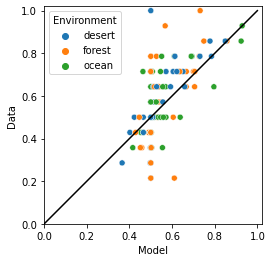

In [17]:
m = fitted.groupby(['Source', 'SubjNum', 'Environment'])['Accuracy'].mean().unstack(level=0)
g = sns.scatterplot(x='Model', y='Data', hue='Environment', data=m.reset_index());
g.set_xlim(0, 1.02);
g.set_ylim(0, 1.02);
g.set_aspect(1);
g.plot((0, 1), (0, 1), '-k');

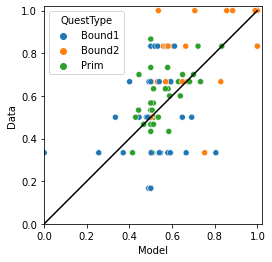

In [18]:
m = fitted.groupby(['Source', 'SubjNum', 'QuestType'])['Accuracy'].mean().unstack(level=0)
g = sns.scatterplot(x='Model', y='Data', hue='QuestType', data=m.reset_index());
g.set_xlim(0, 1.02);
g.set_ylim(0, 1.02);
g.set_aspect(1);
g.plot((0, 1), (0, 1), '-k');

## Plot group means

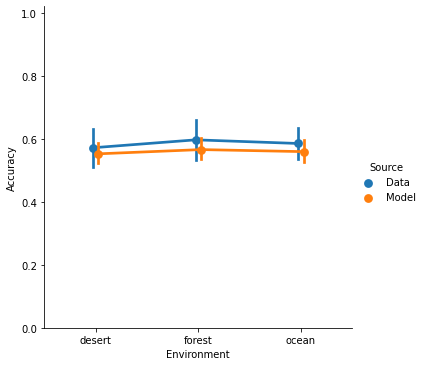

In [19]:
m = fitted.groupby(['Source', 'SubjNum', 'Environment'])['Accuracy'].mean()
g = sns.catplot(kind='point', x='Environment', y='Accuracy', 
                hue='Source', dodge=True, data=m.reset_index())
g.set(ylim=(0, 1.02));

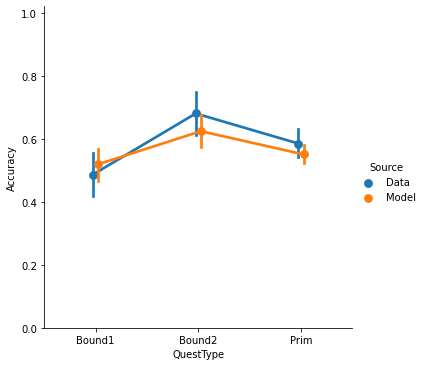

In [20]:
m = fitted.groupby(['Source', 'SubjNum', 'QuestType'])['Accuracy'].mean()
g = sns.catplot(kind='point', x='QuestType', y='Accuracy', 
                hue='Source', dodge=True, data=m.reset_index())
g.set(ylim=(0, 1.02));

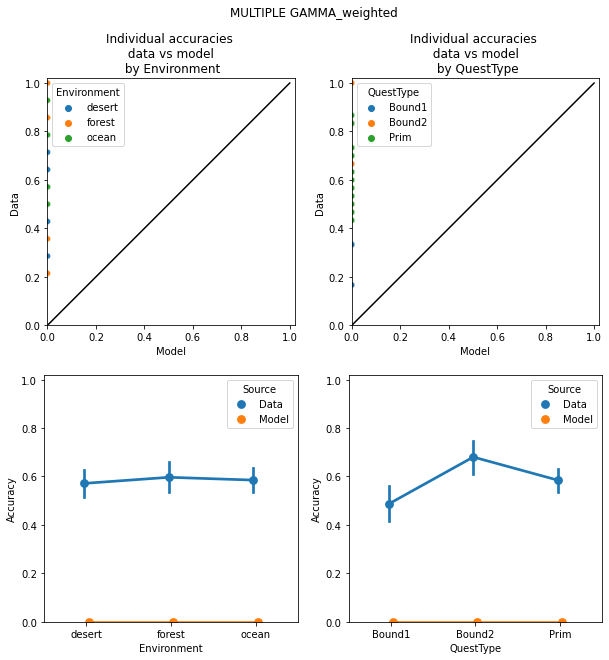

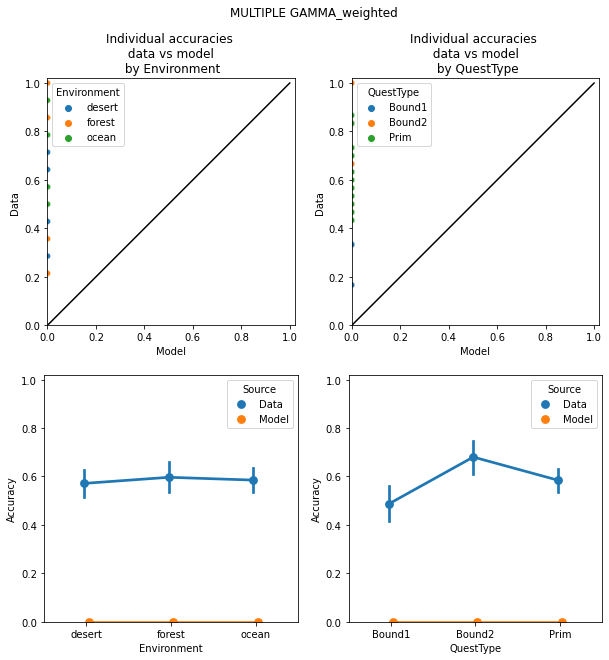

In [21]:
cython_fit.plot_by_question(struct_all, induct_all, results, n_states, True, model_type='multiple gamma')

In [22]:
import importlib
importlib.reload(cython_fit)

<module 'tesser.cython_fit' from '/home/work-machine/Preston_Lab/tesser_successor/tesser/cython_fit.py'>